# New metrics

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib; matplotlib.use('TkAgg')
import seaborn as sns 
import torch
import torch.nn.functional as F
    
from torch.autograd import Variable
import torchvision.transforms as transforms

from utils import *
from models import *
from dataloader import *

%matplotlib inline

## Data

In [2]:
transforms_ = [
        transforms.Resize((256, 256), Image.BICUBIC),
        transforms.ToTensor(),
        min_max_scaling(range = [-1,1]),
    ]

dataset_name = 'DCE-MRI'
data_loader = Loader(input_sequence = "d2", output_sequence = "d5", dataset_name = dataset_name,
                     data_path="/media/ruben-kubuntu/Datos/breast_data/",
                     #data_path="/media/ruben-kubuntu/Datos/duke_data/Duke_tiff/", quality = "1T",
                     batch_size = 5, img_res=(256, 256), roi_size = (64,64), n_channels = 1, 
                     transforms = transforms_)

/home/ruben-kubuntu/venvs/dino_env/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/ruben-kubuntu/venvs/dino_env/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


## Nets

In [8]:
# Initialize generator and discriminator
generator = GeneratorUNet(n_channels = 1).cuda()
# generator.load_state_dict(torch.load("{0}/saved_models/G_chkp_{1}.pth".format("Results/exp_2/d2-d5_WGGP", 200))) #
# generator.load_state_dict(torch.load("{0}/saved_models/G_chkp_{1}.pth".format("Results/exp_2/d2-d5_WGGP_CA", 200))) #

# generator.load_state_dict(torch.load("{0}/saved_models/G_chkp_{1}.pth".format("Results/exp_2/d2-d5_WG", 200))) #
# generator.load_state_dict(torch.load("{0}/saved_models/G_chkp_{1}.pth".format("Results/exp_2/d2-d5_WG_CA", 200))) #

generator.load_state_dict(torch.load("{0}/saved_models/G_chkp_{1}.pth".format("Results/exp_2/d2-d5_PG", 200))) #
#generator.load_state_dict(torch.load("{0}/saved_models/G_chkp_{1}.pth".format("Results/exp_2/d2-d5_PG_CA", 200))) #


ca_loss = torch.nn.L1Loss().cuda()

## Metrics

In [4]:
Tensor = torch.cuda.FloatTensor
difference = True
lucky = np.arange(10)

In [9]:
k = l = 1

img = data_loader.test_generator[int(l)]
real_in  = Variable(img["in" ].type(Tensor)); real_in = real_in[None, :]
real_out = Variable(img["out"].type(Tensor)); real_out = real_out[None, :]
roi_in  = Variable(img["roi_in" ].type(Tensor)); roi_in = roi_in[None, :]
roi_out = Variable(img["roi_out"].type(Tensor)); roi_out = roi_out[None, :]

fake_out = generator(real_in)
roi_fake = extract_roi_from_points(fake_out.cpu().detach().numpy(), img["pt_roi_out"] )
roi_fake = Variable(torch.from_numpy(roi_fake).type(Tensor))

real_ca = real_in - real_out
fake_ca = real_in - fake_out

real_rca = roi_in - roi_out
fake_rca = roi_in - roi_fake

### Metrics

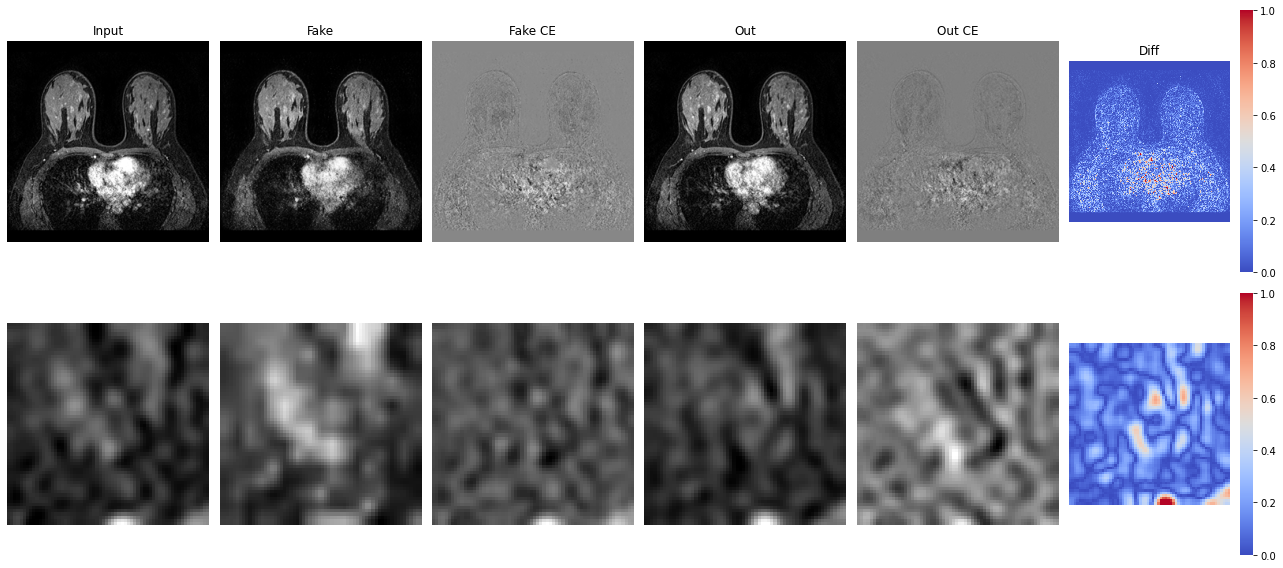

In [10]:
list_imgs = [real_in, fake_out, fake_ca, real_out, real_ca, torch.zeros([10,10]), roi_in, roi_fake, fake_rca, roi_out, real_rca, torch.zeros([10,10])]
list_titles = ["Input", "Fake", "Fake CE", "Out", "Out CE", "Diff", "", "", "", "", "", ""]

num_figs = len(list_imgs)
_, axes = plt.subplots(2,int(num_figs/2), figsize=(18,8))
axes = axes.ravel()

fig_idx = np.arange (num_figs)

for i, image, title in zip(fig_idx, list_imgs, list_titles): 
    #
    #print (image.detach().cpu().numpy().min(), image.detach().cpu().numpy().max(), )
    axes[i].imshow(np.squeeze(image.detach().cpu().numpy()), cmap="gray") #, vmin=-1, vmax=1
    axes[i].set_title(title); axes[i].set_axis_off()

diffmap = abs(np.squeeze(real_ca.detach().cpu().numpy()) - np.squeeze(fake_ca.detach().cpu().numpy())) 
diffroi = abs(np.squeeze(real_rca.detach().cpu().numpy()) - np.squeeze(fake_rca.detach().cpu().numpy()))

sns.heatmap(np.squeeze(diffmap), cmap = "coolwarm", ax=axes[5], vmin=0, vmax=1)
sns.heatmap(np.squeeze(diffroi), cmap = "coolwarm", ax=axes[11], vmin=0, vmax=1)

plt.tight_layout()
#plt.savefig("im_.png", dpi=150)
plt.show()

### NO CA

0.0 2.0 0.0 2.0
0.0 1.9735856
0 1
1 2
0 1
0 1
1 2
0 1
[1] [1]
no ca hits: 65536
no ca hits %: 1.0


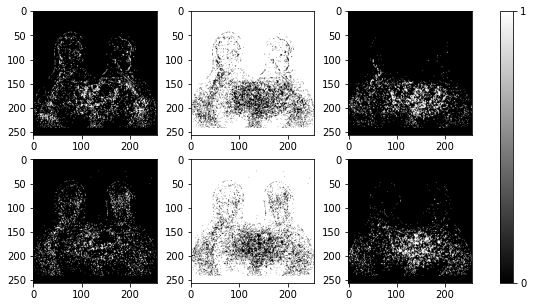

In [34]:
#[real_in, fake_out, fake_ca, real_out, real_ca, torch.zeros([10,10]), roi_in, roi_fake, fake_rca, roi_out, real_rca, 
# NO CA

real_in_arr  = np.squeeze(real_in.cpu().numpy()) +1
real_out_arr = np.squeeze(real_out.cpu().numpy()) +1
fake_out_arr = np.squeeze(fake_out.detach().cpu().numpy()) +1
tolerance = 0.2

print (real_in_arr.min(), real_in_arr.max(), real_out_arr.min(), real_out_arr.max())
print (fake_out_arr.min(), fake_out_arr.max())

real_inc = (np.around(real_in_arr, decimals=3)+tolerance < np.around(real_out_arr, decimals=3)) * 1
fake_inc = (np.around(real_in_arr, decimals=3)+tolerance < np.around(fake_out_arr, decimals=3)) * 1

real_eql = (np.around(real_in_arr, decimals=3)-tolerance <= np.around(real_out_arr, decimals=3)) * 1
fake_eql = (np.around(real_in_arr, decimals=3)-tolerance <= np.around(fake_out_arr, decimals=3)) * 1

real_equ = (np.around(real_in_arr, decimals=3)+tolerance >= np.around(real_out_arr, decimals=3)) * 1
fake_equ = (np.around(real_in_arr, decimals=3)+tolerance >= np.around(fake_out_arr, decimals=3)) * 1

real_eq = (real_eql + real_equ)
fake_eq = (fake_eql + fake_equ)

real_dec = (np.around(real_in_arr, decimals=3)-tolerance > np.around(real_out_arr, decimals=3)) * 1
fake_dec = (np.around(real_in_arr, decimals=3)-tolerance > np.around(fake_out_arr, decimals=3)) * 1


ctags = ["same", "lower", "higher"]
f, axes = plt.subplots(2,3, figsize = (10,5))
axes = axes.ravel()
axes[0].imshow(real_inc, cmap="gray", vmin=0, vmax=1), print(real_inc.min(), real_inc.max())
axes[1].imshow(real_eq , cmap="gray", vmin=1, vmax=2), print(real_eq.min(), real_eq.max())
axes[2].imshow(real_dec, cmap="gray", vmin=0, vmax=1), print(real_dec.min(), real_dec.max())

axes[3].imshow(fake_inc, cmap="gray", vmin=0, vmax=1), print(fake_inc.min(), fake_inc.max())
axes[4].imshow(fake_eq , cmap="gray", vmin=1, vmax=2), print(fake_eq.min(), fake_eq.max())
axs=axes[5].imshow(fake_dec, cmap="gray", vmin=0, vmax=1); print(fake_dec.min(), fake_dec.max())
f = f.colorbar(axs, ax=axes.tolist(), ticks=[0, 1, 2])



print (np.unique((real_inc + real_eq + real_dec)-1), np.unique((fake_inc + fake_eq + fake_dec)-1))

no_ca_matches = ( (fake_inc + fake_eq + fake_dec)-1 == (real_inc + real_eq + real_dec)-1 ) * 1
print ("no ca hits: {0}".format(np.sum(no_ca_matches)))
print ("no ca hits %: {0}".format(np.sum(no_ca_matches)/(no_ca_matches.shape[0]*no_ca_matches.shape[1])))

0.0 2.0 0.0 2.0
0.0 1.9735856
[0 1 2] [0 1 2]
no ca hits: 55339
no ca hits %: 0.8444061279296875


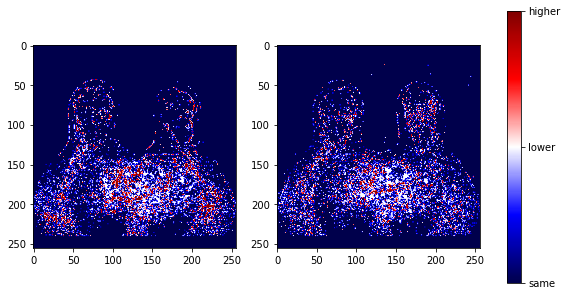

In [36]:

real_in_arr  = np.squeeze(real_in.cpu().numpy()) +1
real_out_arr = np.squeeze(real_out.cpu().numpy()) +1
fake_out_arr = np.squeeze(fake_out.detach().cpu().numpy()) +1
tolerance = 0.2

print (real_in_arr.min(), real_in_arr.max(), real_out_arr.min(), real_out_arr.max())
print (fake_out_arr.min(), fake_out_arr.max())

real_inc = (np.around(real_in_arr, decimals=3)+tolerance < np.around(real_out_arr, decimals=3)) * 3
fake_inc = (np.around(real_in_arr, decimals=3)+tolerance < np.around(fake_out_arr, decimals=3)) * 3

real_eql = (np.around(real_in_arr, decimals=3)-tolerance <= np.around(real_out_arr, decimals=3)) * 1
fake_eql = (np.around(real_in_arr, decimals=3)-tolerance <= np.around(fake_out_arr, decimals=3)) * 1

real_equ = (np.around(real_in_arr, decimals=3)+tolerance >= np.around(real_out_arr, decimals=3)) * 1
fake_equ = (np.around(real_in_arr, decimals=3)+tolerance >= np.around(fake_out_arr, decimals=3)) * 1

real_eq = (real_eql + real_equ)-1
fake_eq = (fake_eql + fake_equ)-1

real_dec = (np.around(real_in_arr, decimals=3)-tolerance > np.around(real_out_arr, decimals=3)) * 2
fake_dec = (np.around(real_in_arr, decimals=3)-tolerance > np.around(fake_out_arr, decimals=3)) * 2


ctags = ["same", "lower", "higher"]
f, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow((real_inc + real_eq + real_dec)-1, cmap="seismic")
# axes[1].imshow(fake_inc + fake_eq + fake_dec, cmap="coolwarm")
f = f.colorbar(axes[1].imshow((fake_inc + fake_eq + fake_dec)-1, cmap="seismic"), ax=axes.tolist(), ticks=[0, 1, 2])
f.ax.set_yticklabels(ctags) 



print (np.unique((real_inc + real_eq + real_dec)-1), np.unique((fake_inc + fake_eq + fake_dec)-1))

no_ca_matches = ( (fake_inc + fake_eq + fake_dec)-1 == (real_inc + real_eq + real_dec)-1 ) * 1
print ("no ca hits: {0}".format(np.sum(no_ca_matches)))
print ("no ca hits %: {0}".format(np.sum(no_ca_matches)/(no_ca_matches.shape[0]*no_ca_matches.shape[1])))

### CA

0.0 2.0 0.0 2.0
0.0 1.9735856
no ca hits: 55339
no ca hits %: 0.8444061279296875


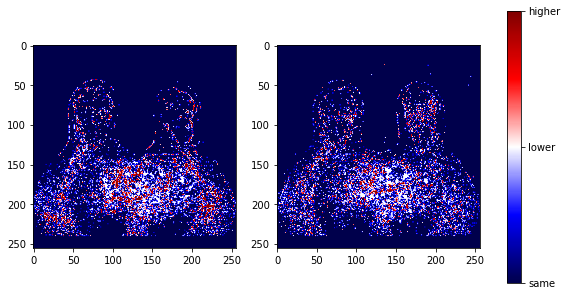

In [27]:
#[real_in, fake_out, fake_ca, real_out, real_ca, torch.zeros([10,10]), roi_in, roi_fake, fake_rca, roi_out, real_rca, 
# CA

real_in_arr  = np.squeeze(real_in.cpu().numpy()) +1
real_out_arr = np.squeeze(real_out.cpu().numpy()) +1
fake_out_arr = np.squeeze(fake_out.detach().cpu().numpy()) +1
tolerance = 0.2

print (real_in_arr.min(), real_in_arr.max(), real_out_arr.min(), real_out_arr.max())
print (fake_out_arr.min(), fake_out_arr.max())

real_inc = (np.around(real_in_arr, decimals=3)+tolerance < np.around(real_out_arr, decimals=3)) * 3
fake_inc = (np.around(real_in_arr, decimals=3)+tolerance < np.around(fake_out_arr, decimals=3)) * 3

real_eql = (np.around(real_in_arr, decimals=3)-tolerance <= np.around(real_out_arr, decimals=3)) * 1
fake_eql = (np.around(real_in_arr, decimals=3)-tolerance <= np.around(fake_out_arr, decimals=3)) * 1

real_equ = (np.around(real_in_arr, decimals=3)+tolerance >= np.around(real_out_arr, decimals=3)) * 1
fake_equ = (np.around(real_in_arr, decimals=3)+tolerance >= np.around(fake_out_arr, decimals=3)) * 1

real_eq = (real_eql + real_equ)-1
fake_eq = (fake_eql + fake_equ)-1

real_dec = (np.around(real_in_arr, decimals=3)-tolerance > np.around(real_out_arr, decimals=3)) * 2
fake_dec = (np.around(real_in_arr, decimals=3)-tolerance > np.around(fake_out_arr, decimals=3)) * 2


ctags = ["same", "lower", "higher"]
f, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow((real_inc + real_eq + real_dec)-1, cmap="seismic")
# axes[1].imshow(fake_inc + fake_eq + fake_dec, cmap="coolwarm")
f = f.colorbar(axes[1].imshow((fake_inc + fake_eq + fake_dec)-1, cmap="seismic"), ax=axes.tolist(), ticks=[0, 1, 2])
f.ax.set_yticklabels(ctags) 


ca_matches = ( (fake_inc + fake_eq + fake_dec)-1 == (real_inc + real_eq + real_dec)-1 ) * 1
print ("no ca hits: {0}".format(np.sum(ca_matches)))
print ("no ca hits %: {0}".format(np.sum(ca_matches)/(ca_matches.shape[0]*ca_matches.shape[1])))

### Add

In [12]:
#print (real_in_arr[30:40, :10], "\n\n", real_out_arr[30:40, :10], "\n\n", real_inc[30:40, :10], "\n\n",  fake_out_arr[:10, :10])

real_eq = (np.around(real_in_arr, decimals=3) == np.around(real_out_arr, decimals=3)) * 1
fake_eq = (np.around(real_in_arr, decimals=3) == np.around(fake_out_arr, decimals=3)) * 1

real_eq_counts = np.unique(real_eq, return_counts=True)
fake_eq_counts = np.unique(fake_eq, return_counts=True)

print (real_eq_counts, fake_eq_counts)

(array([0, 1]), array([52830, 12706])) (array([0, 1]), array([57913,  7623]))


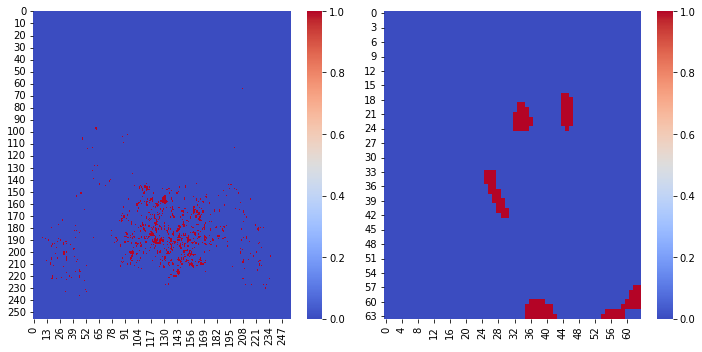

In [13]:
diffmap, diffroi

diffmap_T = (diffmap > 0.5 )*1.0
diffroi_T = (diffroi > 0.5 )*1.0

_, axes = plt.subplots(1,2, figsize=(10,5))
sns.heatmap(np.squeeze(diffmap_T), cmap = "coolwarm", ax=axes[0], vmin=0, vmax=1)
sns.heatmap(np.squeeze(diffroi_T), cmap = "coolwarm", ax=axes[1], vmin=0, vmax=1)

plt.tight_layout()
plt.show()

In [14]:
for k, l in tqdm(enumerate(lucky), ncols=100):
    #
    try:
        img = data_loader.test_generator[int(l)]
        real_in  = Variable(img["in" ].type(Tensor)); real_in = real_in[None, :]
        real_out = Variable(img["out"].type(Tensor)); real_out = real_out[None, :]
        roi_in  = Variable(img["roi_in" ].type(Tensor)); roi_in = roi_in[None, :]
        roi_out = Variable(img["roi_out"].type(Tensor)); roi_out = roi_out[None, :]
        
        fake_out = generator(real_in)
        roi_fake = extract_roi_from_points(fake_out.cpu().detach().numpy(), img["pt_roi_out"] )
        
        diffmap = abs(real_out.data - fake_out.data) 
        diffroi = abs(roi_out.data.cpu().numpy() - roi_fake[np.newaxis,:,:,:]) 
        img_sample = [real_in.data.cpu().numpy(), real_out.data.cpu().numpy(), fake_out.data.cpu().numpy(), \
                      roi_in.data.cpu().numpy(), roi_out.data.cpu().numpy(), roi_fake[np.newaxis,:,:,:]]
        diffmaps = [diffmap.cpu().numpy(), diffroi]
    except: 
        continue


10it [00:00, 87.53it/s]


## ss